In [1]:
#Solve ToxicDetection through feature engineer into logistic regression
# Reference this tutorial for the logistic regression: 
##  https://www.kaggle.com/negation/pytorch-logistic-regression-tutorial
%load_ext autoreload
%autoreload 2


In [2]:
#Input Data needs to be in array of size N x (2)
import utils 
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    USE_GPU = False



In [3]:
pd.set_option('display.max_colwidth', -1)
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'dataset')
train = pd.read_csv(os.path.join(data_dir,'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))


train_x, train_y = utils.featurize(train)


In [32]:
def mModel1(input_size, hidden_dim, num_classes=2):
    class LogisticRegression(nn.Module):
        def __init__(self, input_size, hidden_dim, num_classes=2):
            super(LogisticRegression, self).__init__()
            self.linear = nn.Linear(input_size, hidden_dim)
            self.linear2 = nn.Linear(hidden_dim, num_classes)
        def forward(self, x):        
            m = nn.Softmax()
            n = nn.functional.leaky_relu(self.linear(x))
            n2 = self.linear2(n)
            return m(n2)
    return LogisticRegression(input_size, hidden_dim)
        

In [46]:
class modelMaker:

    def __init__(self, model, opt, epochs=300, feature_dims=21, batchSize=32, classes=6, lr=1e-3, hidden_dim=1024, useGpu=False):
        #train on data_train with several epochs
        self.epochs = epochs #Can also be changed. The higher this value, the more overfit. 
        self.feature_dims = feature_dims
        self.batchSize = batchSize
        self.classes = classes #Binaray for toxic, or not
        self.hidden=hidden_dim
        self.lr=lr
        self.model = model
        self.opt = opt
        self.models = []
        self.useGpu = useGpu
        self.lossFns = []
        self.optimizers = []

    #Training
    def train(self, tr_x, tr_y):
        losses = np.zeros((self.classes, self.epochs))
        for c in range(self.classes):                    
            self.models.append(self.model(self.feature_dims, self.hidden))
            if self.useGpu==True:
                self.models[c] = self.models[c].cuda()
            self.lossFns.append(nn.CrossEntropyLoss())
            self.optimizers.append(self.opt(self.models[c].parameters(), lr = self.lr))
            for epoch in range(self.epochs):
                sampleIdx = np.random.choice(np.arange(len(tr_y)), self.batchSize, replace=False)
                x_s = torch.from_numpy(tr_x[sampleIdx]).float().to(device)
                y_s = torch.from_numpy(tr_y[sampleIdx]).long().to(device)
                self.optimizers[c].zero_grad()
                scores = self.models[c](x_s)
                loss = self.lossFns[c](scores, y_s[:,c])
                loss.backward()
                self.optimizers[c].step()
                losses[c, epoch] = loss.data[0]
        return losses

    #Test 
    def test(self, ts_x, ts_y):
        sampleIdx = np.random.choice(np.arange(len(ts_x)), self.batchSize*5, replace=False)
        x = ts_x[sampleIdx]
        if ts_y is not None:
            y = torch.from_numpy(ts_y[sampleIdx]).long().to(device)
            if self.useGpu == True:
                y = y.cuda()
        correct = np.zeros((self.classes))
#         fn = np.zeros((self.classes))
        output = np.zeros((len(x), self.classes))
        for c in range(self.classes):    
            if ts_y is None:
                scores = self.models[c](torch.from_numpy(x).float().to(device)).detach()
                output[:, c] = scores[:, 1]
                
            else:                                   
                for i in range(len(x)):
                    scores = self.models[c](torch.from_numpy(x[i]).float().to(device)).detach()                    
                    pred = torch.argmax(scores, dim=0).to(device)                                        
                    if y[i,c]==pred:
                        correct[c] += 1
#                     if y[i,c] == 1 and pred == 0:
#                         fn[c] += 1                
            
        if ts_y is not None:
            return correct / len(x) #Accuracy
        else:
            return output
                                    


In [10]:
#do something with the data from 5 fold cross validation
print("Validation Accuracy (Precision): ", ValidationAccuracy, "Average: ", np.mean(ValidationAccuracy, axis=1))
print("Validation Recall: ", ValidationRecall, "Average: ", np.mean(ValidationRecall, axis=1))


Validation Accuracy (Precision):  [[ 0.90988281  0.98950304  0.94826722  0.99674124  0.95252867  0.99116375]
 [ 0.90881745  0.99053707  0.95096196  0.99639657  0.95155731  0.99135176]
 [ 0.90687473  0.98981638  0.9466065   0.99730526  0.94964592  0.99204111]
 [ 0.91708968  0.98984772  0.94861189  0.99746193  0.95544275  0.99097575]
 [ 0.916651    0.99025506  0.952466    0.99711725  0.95042928  0.99044307]] Average:  [ 0.96468112  0.96493702  0.96371498  0.96657162  0.96622694]
Validation Recall:  [[ 0.90999687  0.98950304  0.94835637  0.99674124  0.95300646  0.99116375]
 [ 0.9088744   0.99053707  0.95105136  0.99639657  0.95191524  0.99135176]
 [ 0.90687473  0.9900956   0.9466065   0.99730526  0.94964592  0.99204111]
 [ 0.91726213  0.98984772  0.94867135  0.99746193  0.95589203  0.99097575]
 [ 0.91731209  0.99025506  0.9525854   0.99711725  0.95042928  0.99044307]] Average:  [ 0.96479462  0.96502107  0.96376152  0.96668515  0.96635702]


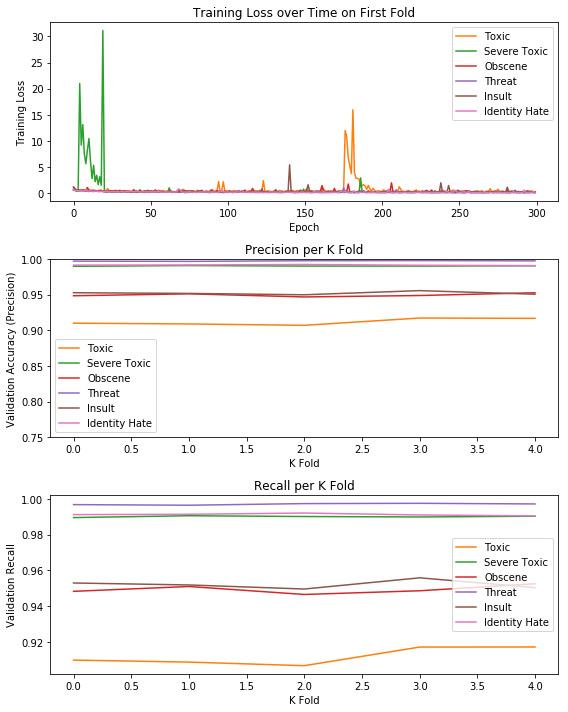

In [15]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(3, 1, figsize=(8,10))
ax1[0].plot(range(len(trainingLoss[0][0])), trainingLoss[0][0], 'C1', label='Toxic')
ax1[0].plot(range(len(trainingLoss[0][0])), trainingLoss[0][1], 'C2', label='Severe Toxic')
ax1[0].plot(range(len(trainingLoss[0][0])), trainingLoss[0][2], 'C3', label='Obscene')
ax1[0].plot(range(len(trainingLoss[0][0])), trainingLoss[0][3], 'C4', label='Threat')
ax1[0].plot(range(len(trainingLoss[0][0])), trainingLoss[0][4], 'C5', label='Insult')
ax1[0].plot(range(len(trainingLoss[0][0])), trainingLoss[0][5], 'C6', label='Identity Hate')
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Training Loss')
ax1[0].set_title('Training Loss over Time on First Fold')
ax1[0].legend()

ax1[1].plot(range(len(ValidationAccuracy)), ValidationAccuracy[:,0], 'C1', label='Toxic')
ax1[1].plot(range(len(ValidationAccuracy)), ValidationAccuracy[:,1], 'C2', label='Severe Toxic')
ax1[1].plot(range(len(ValidationAccuracy)), ValidationAccuracy[:,2], 'C3', label='Obscene')
ax1[1].plot(range(len(ValidationAccuracy)), ValidationAccuracy[:,3], 'C4', label='Threat')
ax1[1].plot(range(len(ValidationAccuracy)), ValidationAccuracy[:,4], 'C5', label='Insult')
ax1[1].plot(range(len(ValidationAccuracy)), ValidationAccuracy[:,5], 'C6', label='Identity Hate')
ax1[1].set_xlabel('K Fold')
ax1[1].set_ylabel('Validation Accuracy (Precision)')
ax1[1].set_title('Precision per K Fold')
ax1[1].set_ylim([0.75,1])
ax1[1].legend()


ax1[2].plot(range(len(ValidationRecall)), ValidationRecall[:,0], 'C1', label='Toxic')
ax1[2].plot(range(len(ValidationRecall)), ValidationRecall[:,1], 'C2', label='Severe Toxic')
ax1[2].plot(range(len(ValidationRecall)), ValidationRecall[:,2], 'C3', label='Obscene')
ax1[2].plot(range(len(ValidationRecall)), ValidationRecall[:,3], 'C4', label='Threat')
ax1[2].plot(range(len(ValidationRecall)), ValidationRecall[:,4], 'C5', label='Insult')
ax1[2].plot(range(len(ValidationRecall)), ValidationRecall[:,5], 'C6', label='Identity Hate')
ax1[2].set_xlabel('K Fold')
ax1[2].set_ylabel('Validation Recall')
ax1[2].set_title('Recall per K Fold')
ax1[2].legend()


fig1.tight_layout()
plt.show()




In [11]:
#Run Test set on regular base values and regular parameters
epoch=150
batch=32
classes=6
lr=1e-3
full = modelMaker(epochs=epoch, batchSize=batch, classes=classes, lr=lr, useGpu=torch.cuda.is_available())
s = full.train(train_x, train_y)

C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [12]:
test_x, _ = utils.featurize(test, stage='test')
test_y = full.test(test_x, None)

C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [50]:
print(test_y)

file = open("test_labels.csv", "w")
for i in range(len(test_x)):
    file.write(str(test.values[i][0]) + "," +",".join(str(int(x)) for x in test_y[i].tolist()))
    file.write("\n")

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [52]:
def mModel2(input_size, hidden_dim, num_classes=2):
    class model2(nn.Module):
        def __init__(self, input_size, hidden_dim, num_classes=2):
            super(model2, self).__init__()        
            self.linear = nn.Linear(input_size, hidden_dim)
            self.linear2 = nn.Linear(hidden_dim, hidden_dim)
            self.linear3 = nn.Linear(hidden_dim, hidden_dim)
            self.linear4 = nn.Linear(hidden_dim, num_classes)
        def forward(self, x):        
            m = nn.Softmax()
            n = nn.functional.leaky_relu(self.linear(x))
            n = nn.functional.dropout(n, p=0.3)
            n = nn.functional.leaky_relu(self.linear2(n))
            n = nn.functional.dropout(n, p=0.3)
            n = nn.functional.leaky_relu(self.linear3(n))
            n = nn.functional.dropout(n, p=0.3)
            n = self.linear4(n)        
            return m(n)
    return model2(input_size, hidden_dim)
    
def adamM(params, lr):
    return torch.optim.Adam(params, lr=lr)

def RMSpropM(params, lr):
    return torch.optim.RMSprop(params, lr=lr)

def sgdM(params, lr):
    return torch.optim.SGD(params, lr=lr)
    

In [54]:
#TODO:
#Optimize hyperparameters like batchsize, or learning rate or
#Try to add dropout, batch normalization to get highest val acc

#Run 5fold cross validation
k = 5
epochs = [100,200,300]
feature_dims = 21
batchSize = [16, 32, 64]
learnRates = [1e-5, 1e-3, 1e-1]
hidden = [256, 512, 1024]
modelss = [ mModel1 , mModel2 ]
optims = [ adamM, RMSpropM, sgdM ]
optD = {0:'Adam', 1:'RMS', 2:'SGD'}
classes = 6
ValidationSize = int(len(train_x) / k)
allAccuracy = {}
allTrainingLoss = {}
counter = 0

for mo in range(len(modelss)):
    for hidd in hidden:
        for opt in range(len(optims)):
            for e in epochs:
                for bs in batchSize:
                    for lr in learnRates:
                        ValidationAccuracy = np.zeros((k, classes))            
                        trainingLoss = np.zeros((k, classes, e))
                        cou = 0
                        for i in range(0, len(train_x), ValidationSize):
                            if cou == 5:
                                break
                            val_x, val_y = train_x[i:i+ValidationSize,:], train_y[i:i+ValidationSize,:]
                            tr_x = np.concatenate([train_x[:i],train_x[i+ValidationSize:]])
                            tr_y = np.concatenate([train_y[:i],train_y[i+ValidationSize:]])
                            m = modelMaker(modelss[mo], optims[opt], epochs=e, batchSize=bs, lr=lr, hidden_dim=hidd, useGpu=torch.cuda.is_available())
                            trainingLoss[cou] = m.train(tr_x, tr_y)                
                            #Calculate Validation 
                            ValidationAccuracy[cou] = m.test(val_x, val_y)
                            cou+=1
                        allAccuracy[(e,bs,lr,mo,hidd,opt)] = ValidationAccuracy
                        allTrainingLoss[(e,bs,lr,mo,hidd,opt)] = trainingLoss
                        counter+=1
                        print("{} : Epoch:{}, Batch Size: {}, Learning Rate:{:.4}, Model:{}, hidd:{}, Opt:{}, Average Val Accuracy:{:.4}".format(counter, e,bs,lr,mo,hidd,optD[opt],np.mean(ValidationAccuracy)))
    
    




C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1 : Epoch:100, Batch Size: 16, Learning Rate:1e-05, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.7238
2 : Epoch:100, Batch Size: 16, Learning Rate:0.001, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.9538
3 : Epoch:100, Batch Size: 16, Learning Rate:0.1, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.965
4 : Epoch:100, Batch Size: 32, Learning Rate:1e-05, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.6358
5 : Epoch:100, Batch Size: 32, Learning Rate:0.001, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.9562
6 : Epoch:100, Batch Size: 32, Learning Rate:0.1, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.9654
7 : Epoch:100, Batch Size: 64, Learning Rate:1e-05, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.6388
8 : Epoch:100, Batch Size: 64, Learning Rate:0.001, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.9643
9 : Epoch:100, Batch Size: 64, Learning Rate:0.1, Model:0, hidd:256, Opt:Adam, Average Val Accuracy:0.9622
10 : Epoch:200, Batch Size

77 : Epoch:300, Batch Size: 32, Learning Rate:0.001, Model:0, hidd:256, Opt:SGD, Average Val Accuracy:0.9725
78 : Epoch:300, Batch Size: 32, Learning Rate:0.1, Model:0, hidd:256, Opt:SGD, Average Val Accuracy:0.9629
79 : Epoch:300, Batch Size: 64, Learning Rate:1e-05, Model:0, hidd:256, Opt:SGD, Average Val Accuracy:0.7028
80 : Epoch:300, Batch Size: 64, Learning Rate:0.001, Model:0, hidd:256, Opt:SGD, Average Val Accuracy:0.9682
81 : Epoch:300, Batch Size: 64, Learning Rate:0.1, Model:0, hidd:256, Opt:SGD, Average Val Accuracy:0.9633
82 : Epoch:100, Batch Size: 16, Learning Rate:1e-05, Model:0, hidd:512, Opt:Adam, Average Val Accuracy:0.8017
83 : Epoch:100, Batch Size: 16, Learning Rate:0.001, Model:0, hidd:512, Opt:Adam, Average Val Accuracy:0.9633
84 : Epoch:100, Batch Size: 16, Learning Rate:0.1, Model:0, hidd:512, Opt:Adam, Average Val Accuracy:0.97
85 : Epoch:100, Batch Size: 32, Learning Rate:1e-05, Model:0, hidd:512, Opt:Adam, Average Val Accuracy:0.7973
86 : Epoch:100, Batch S

153 : Epoch:200, Batch Size: 64, Learning Rate:0.1, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.9642
154 : Epoch:300, Batch Size: 16, Learning Rate:1e-05, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.6512
155 : Epoch:300, Batch Size: 16, Learning Rate:0.001, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.9658
156 : Epoch:300, Batch Size: 16, Learning Rate:0.1, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.9596
157 : Epoch:300, Batch Size: 32, Learning Rate:1e-05, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.6429
158 : Epoch:300, Batch Size: 32, Learning Rate:0.001, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.9644
159 : Epoch:300, Batch Size: 32, Learning Rate:0.1, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.9648
160 : Epoch:300, Batch Size: 64, Learning Rate:1e-05, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.6366
161 : Epoch:300, Batch Size: 64, Learning Rate:0.001, Model:0, hidd:512, Opt:SGD, Average Val Accuracy:0.9686
162 : Epoch:300,

228 : Epoch:200, Batch Size: 16, Learning Rate:0.1, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.9617
229 : Epoch:200, Batch Size: 32, Learning Rate:1e-05, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.6438
230 : Epoch:200, Batch Size: 32, Learning Rate:0.001, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.9635
231 : Epoch:200, Batch Size: 32, Learning Rate:0.1, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.9669
232 : Epoch:200, Batch Size: 64, Learning Rate:1e-05, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.5728
233 : Epoch:200, Batch Size: 64, Learning Rate:0.001, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.9657
234 : Epoch:200, Batch Size: 64, Learning Rate:0.1, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.9644
235 : Epoch:300, Batch Size: 16, Learning Rate:1e-05, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.7967
236 : Epoch:300, Batch Size: 16, Learning Rate:0.001, Model:0, hidd:1024, Opt:SGD, Average Val Accuracy:0.9667
237 : E

C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


244 : Epoch:100, Batch Size: 16, Learning Rate:1e-05, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.9563
245 : Epoch:100, Batch Size: 16, Learning Rate:0.001, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.975
246 : Epoch:100, Batch Size: 16, Learning Rate:0.1, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.9492
247 : Epoch:100, Batch Size: 32, Learning Rate:1e-05, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.9644
248 : Epoch:100, Batch Size: 32, Learning Rate:0.001, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.961
249 : Epoch:100, Batch Size: 32, Learning Rate:0.1, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.9571
250 : Epoch:100, Batch Size: 64, Learning Rate:1e-05, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.9456
251 : Epoch:100, Batch Size: 64, Learning Rate:0.001, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.9611
252 : Epoch:100, Batch Size: 64, Learning Rate:0.1, Model:1, hidd:256, Opt:Adam, Average Val Accuracy:0.9558
253 : Epo

319 : Epoch:300, Batch Size: 32, Learning Rate:1e-05, Model:1, hidd:256, Opt:SGD, Average Val Accuracy:0.4937
320 : Epoch:300, Batch Size: 32, Learning Rate:0.001, Model:1, hidd:256, Opt:SGD, Average Val Accuracy:0.9596
321 : Epoch:300, Batch Size: 32, Learning Rate:0.1, Model:1, hidd:256, Opt:SGD, Average Val Accuracy:0.964
322 : Epoch:300, Batch Size: 64, Learning Rate:1e-05, Model:1, hidd:256, Opt:SGD, Average Val Accuracy:0.5424
323 : Epoch:300, Batch Size: 64, Learning Rate:0.001, Model:1, hidd:256, Opt:SGD, Average Val Accuracy:0.9629
324 : Epoch:300, Batch Size: 64, Learning Rate:0.1, Model:1, hidd:256, Opt:SGD, Average Val Accuracy:0.9596
325 : Epoch:100, Batch Size: 16, Learning Rate:1e-05, Model:1, hidd:512, Opt:Adam, Average Val Accuracy:0.965
326 : Epoch:100, Batch Size: 16, Learning Rate:0.001, Model:1, hidd:512, Opt:Adam, Average Val Accuracy:0.9642
327 : Epoch:100, Batch Size: 16, Learning Rate:0.1, Model:1, hidd:512, Opt:Adam, Average Val Accuracy:0.9317
328 : Epoch:100

394 : Epoch:200, Batch Size: 64, Learning Rate:1e-05, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.4962
395 : Epoch:200, Batch Size: 64, Learning Rate:0.001, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.9622
396 : Epoch:200, Batch Size: 64, Learning Rate:0.1, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.9679
397 : Epoch:300, Batch Size: 16, Learning Rate:1e-05, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.5712
398 : Epoch:300, Batch Size: 16, Learning Rate:0.001, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.9542
399 : Epoch:300, Batch Size: 16, Learning Rate:0.1, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.9637
400 : Epoch:300, Batch Size: 32, Learning Rate:1e-05, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.5269
401 : Epoch:300, Batch Size: 32, Learning Rate:0.001, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.9596
402 : Epoch:300, Batch Size: 32, Learning Rate:0.1, Model:1, hidd:512, Opt:SGD, Average Val Accuracy:0.9594
403 : Epoch:300,

469 : Epoch:200, Batch Size: 16, Learning Rate:1e-05, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.5021
470 : Epoch:200, Batch Size: 16, Learning Rate:0.001, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.9596
471 : Epoch:200, Batch Size: 16, Learning Rate:0.1, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.9658
472 : Epoch:200, Batch Size: 32, Learning Rate:1e-05, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.5623
473 : Epoch:200, Batch Size: 32, Learning Rate:0.001, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.9583
474 : Epoch:200, Batch Size: 32, Learning Rate:0.1, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.9658
475 : Epoch:200, Batch Size: 64, Learning Rate:1e-05, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.6234
476 : Epoch:200, Batch Size: 64, Learning Rate:0.001, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.96
477 : Epoch:200, Batch Size: 64, Learning Rate:0.1, Model:1, hidd:1024, Opt:SGD, Average Val Accuracy:0.96
478 : Epoch